In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h5>Rough Draft</h5>

Types of models to use :
* Linear Regression (Check if underfit with plots)
    - Log transform skewed distributions
* KNN
* XGBoost
* https://automl.github.io/auto-sklearn/master/

How to finetune model:
* param grid tuning
* Cross Validation
* K Best features
* R-squared, Adjusted R-squared

How to interpret model:
* Feature Importance
* Permutation Importance
* SHAP values and plots
* Partial Dependence Plots (1 and 2D)



GroupKFold (K = 4, Group by country, then remove country)

Pipeline (Scale, PCA)

In [2]:
df = pd.read_csv('../data/interim/radius3_selected_features.csv',index_col=[0])
X = df.drop(['Gini index','Country Name'],axis=1).to_numpy()

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()

In [3]:
df.head()

,Year,"EA, at least completed lower secondary","EA, Doctoral or equivalent",Inflation,GDP (current US$),"COD, by injury","EA, at least Master's or equivalent","EA, at least completed short-cycle tertiary","Population, total",Unemployment,...,"Physicians (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65,Poverty headcount ratio at $6.85,Poverty gap at $2.15,Poverty gap at $3.65,Poverty headcount ratio at $2.15,Poverty gap at $6.85,GDP per capita
11420,2002,88.543221,0.00000,0.757421,4.395616e+10,8.507397,16.28310,38.141708,48202470.0,10.140,...,3.0188,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,0.00000,5.179678,5.201035e+10,8.507397,16.28310,38.141708,47812949.0,9.060,...,3.0096,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,0.03193,10.230103,3.802571e+09,10.150055,15.44759,17.622650,5268400.0,2.677,...,2.3580,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,0.25529,4.168633,2.129598e+10,12.359977,2.37209,21.358910,3431614.0,5.844,...,1.3032,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,0.79249,4.060305,2.754475e+11,5.055017,9.20796,30.182824,4489544.0,6.770,...,4.0144,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


<h5>Preprocessing</h5>
Below I set up the initial pipeline that preprocesses the data and splits it into folds.

* since values between countries were imputed, Group K fold seperates the data and makes sure that countries don't overlap.
* Each fold is then standard scaled with the rest of the folds
* In a similar way I use PCA to reduce the 6 poverty features into 2

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

preprocess_steps = [('scaler',StandardScaler()),
                    ('ct',ColumnTransformer([('pca',PCA(n_components=2),list(range(13,19)))],remainder='passthrough'))]

In [5]:
from sklearn.pipeline import Pipeline

Pipeline(steps=preprocess_steps)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  [13, 14, 15, 16, 17, 18])]))])

In [6]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

<h5>Linear models</h5>

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,cross_val_predict


ols = Pipeline(steps=preprocess_steps+[('ols',LinearRegression())])
test_scores = cross_val_score(ols,X,y,groups=groups,cv=gkf)

In [8]:
np.average(test_scores)

-0.18134186448028725

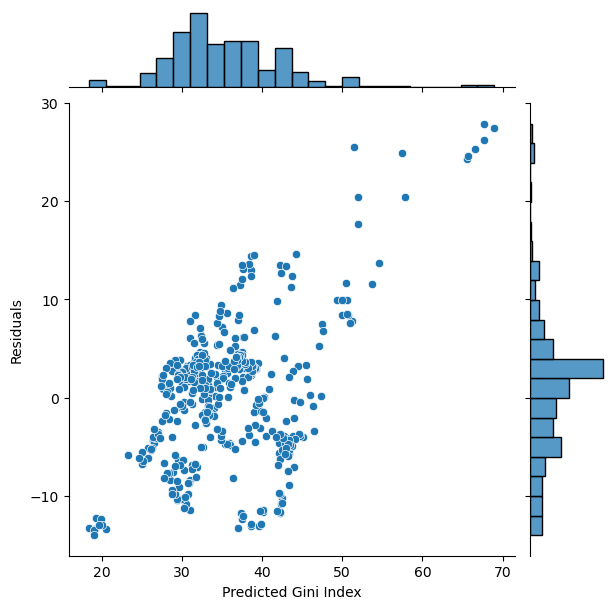

In [9]:
preds = cross_val_predict(ols,X,y,groups=groups,cv=gkf)

sns.jointplot(x=preds,y=preds-y)
plt.xlabel('Predicted Gini Index')
plt.ylabel('Residuals')
plt.show()


Since there's correlation in the residuals and Gini Index isn't normally distributed, Linear regression (or atleast ordinary least squares) isn't a good fit for the data.

* I next tried LassoLars which includes a regularization parameter to prevent overfitting and increases coefficents of features in a forward stepwise manner. 
* Although it doesn't change the fact that the data doesn't fit a linear model, it's coefficients give good insight into which features are most important and the direction of that relationship. 



In [10]:
from sklearn.linear_model import LassoLars

lars = Pipeline(steps=preprocess_steps+[('lars',LassoLars())])

test_scores = cross_val_score(lars,X,y,groups=groups,cv=gkf)

In [11]:
print(np.average(test_scores))

0.259553239336359


In [12]:
columns = df.drop(['Country Name', 'Gini index'],axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]

feature_names = ['poverty_pca0','poverty_pca1'] + feature_names #the column transformer outputs features in this order

In [13]:
folds = gkf.split(X,y,groups=groups)
coefs = {}
for f in feature_names:
    coefs[f] = []
for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    lars.fit(X_train,y_train)
    fold_coefs = lars.named_steps['lars'].coef_
    
    for j in range(len(feature_names)):
        coefs[feature_names[j]].append(fold_coefs[j])

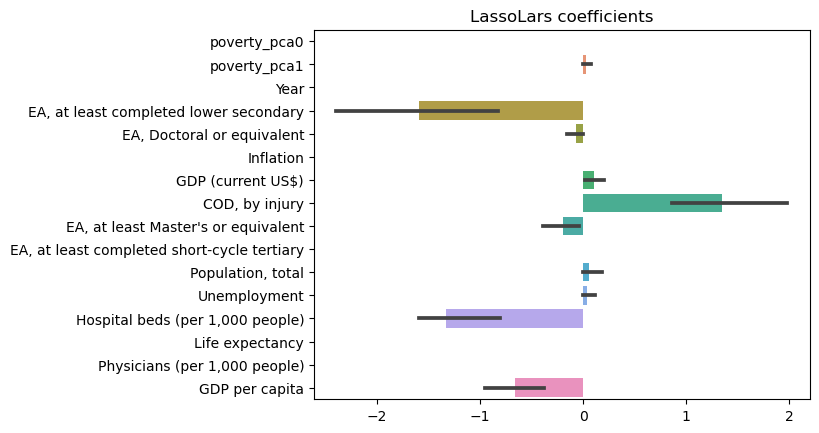

In [14]:
sns.barplot(pd.DataFrame(coefs),orient='h')
plt.title('LassoLars coefficients');

Since all the variables are standard scaled, The coefficients can compared directly.

According to lasso the most important variables in order are:
- Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)
- Cause of death, by injury (% of total)
- Hospital beds (per 1,000 people)  
- GDP per capita

<h5>K Neighbors Regression</h5>

In [15]:

from sklearn.neighbors import KNeighborsRegressor

KNN = Pipeline(steps=preprocess_steps+[('knn',KNeighborsRegressor())])

test_scores = cross_val_score(KNN,X,y,groups=groups,cv=gkf)

In [16]:
print(test_scores)

[0.22275349 0.61391674 0.86011643 0.17689441 0.66113275]


In [17]:
np.average(test_scores)

0.5069627642472494

In [18]:
from sklearn.model_selection import cross_validate

avg_train_scores = []
avg_test_scores = []
nn_range = range(2,20)

for nn in nn_range:
    train_scores = []
    test_scores = []
    knn = KNN.set_params(knn__n_neighbors=nn)
    scores = cross_validate(knn,X,y,groups=groups,cv=gkf,return_train_score=True)
    
    avg_train_scores.append(np.average(scores['train_score']))
    avg_test_scores.append(np.average(scores['test_score']))

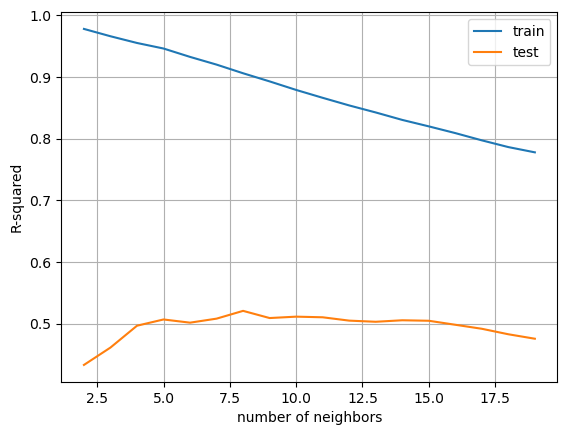

In [19]:
plt.plot(nn_range,avg_train_scores) # type: ignore
plt.plot(nn_range,avg_test_scores) # type: ignore
plt.grid(True)
plt.xlabel('number of neighbors')
plt.ylabel('R-squared')
plt.legend({'train':'blue','test':'orange'})
plt.show()

In [20]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

avg_train_scores = []
avg_test_scores = []

pipeline = Pipeline(steps=preprocess_steps+[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

for k_val in range(1,16):
    
    model = pipeline.set_params(skb__k=k_val,skb__score_func=mutual_info_regression,knn__n_neighbors=8)

    scores = cross_validate(model,X,y,groups=groups,cv=gkf,return_train_score=True)
    
    avg_train_scores.append(np.average(scores['train_score']))
    avg_test_scores.append(np.average(scores['test_score']))
    

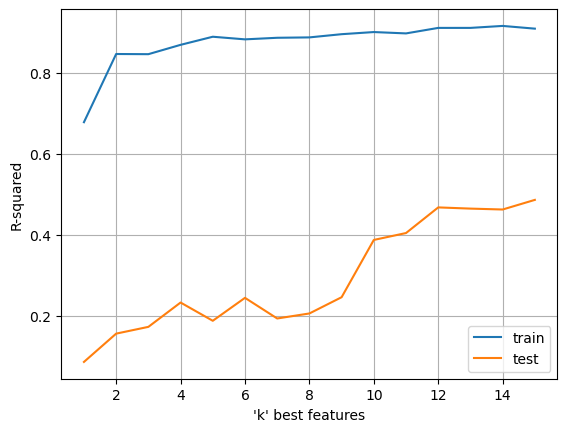

In [21]:
plt.plot(range(1,16),avg_train_scores) # type: ignore
plt.plot(range(1,16),avg_test_scores) # type: ignore
plt.grid(True)
plt.xlabel("'k' best features")
plt.ylabel('R-squared')
plt.legend({'train':'blue','test':'orange'})
plt.show()


The dip in the middle shows that select K best features may not be selecting optimally

Next I run a grid search to tune the parameters for K nearest neighbors

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression,r_regression,mutual_info_regression

pipeline = Pipeline(steps=preprocess_steps+[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

params = {
    'skb__k':range(1,16),                                                 #how many features to select
    'skb__score_func':[mutual_info_regression,f_regression,r_regression], #how to select features
    'knn__n_neighbors':range(5,15),                                       #number of neighbors
    'knn__weights':['uniform','distance'],                                #weigh all neighbors uniformly or by distance
    'knn__p':[1,2,3]                                                      # how to measure distance, manhattan, euclidean, etc.
}

grid_search = GridSearchCV(pipeline,params,cv=gkf)

grid_search.fit(X,y,groups=groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pca',
                                                                         PCA(n_components=2),
                                                                         [13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18])])),
                                       ('skb', SelectKBest()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(5, 15), 'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance'],
                         'skb__k': range(1, 16),
                         'skb__score_func': [<function mutual_info_regression at 0x14ddbede0>,
                                             <function f_regression at 0x16813cfe0>,
                                             <function r_regression at 0x16813cea0>]})

In [23]:
grid_search.best_score_

0.5923053509911974

In [24]:
grid_search.best_params_

{'knn__n_neighbors': 12,
 'knn__p': 1,
 'knn__weights': 'uniform',
 'skb__k': 15,
 'skb__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

So the best KNN model explains about 60% of the variance and uses 15 of the 16 features

In [25]:
skb = SelectKBest(score_func=mutual_info_regression,k=15)

pipe = Pipeline(preprocess_steps)

X_transformed = pipe.fit_transform(X,y)

skb.fit(X_transformed,y)
best_features=skb.get_feature_names_out(feature_names) # type: ignore 

In [26]:
best_features

array(['poverty_pca0', 'poverty_pca1',
       'EA, at least completed lower secondary',
       'EA, Doctoral or equivalent', 'Inflation', 'GDP (current US$)',
       'COD, by injury', "EA, at least Master's or equivalent",
       'EA, at least completed short-cycle tertiary', 'Population, total',
       'Unemployment', 'Hospital beds (per 1,000 people)',
       'Life expectancy', 'Physicians (per 1,000 people)',
       'GDP per capita'], dtype=object)

In [27]:
set(df.columns) - set(best_features)

{'Country Name',
 'Gini index',
 'Poverty gap at $2.15',
 'Poverty gap at $3.65',
 'Poverty gap at $6.85',
 'Poverty headcount ratio at $2.15',
 'Poverty headcount ratio at $3.65',
 'Poverty headcount ratio at $6.85',
 'Year'}

The feature it omits is Year

<h5>XG Boost</h5>

In [28]:
from xgboost import XGBRegressor

xgb = Pipeline(preprocess_steps + [('xgb',XGBRegressor())])

test_scores = cross_val_score(xgb,X,y,groups=groups,cv=gkf)

In [29]:
print(test_scores)

[0.28519046 0.62824036 0.82631022 0.06999064 0.67405157]


In [30]:
np.average(test_scores)

0.4967566497536236

In [31]:
folds = gkf.split(X,y,groups=groups)
feature_importances = {}
for f in feature_names:
    feature_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    xgb.fit(X_train,y_train)

    fold_fi = xgb.named_steps['xgb'].feature_importances_
    
    for j in range(len(feature_names)):
        feature_importances[feature_names[j]].append(fold_fi[j])
    




In [32]:
pd.DataFrame(feature_importances)

,poverty_pca0,poverty_pca1,Year,"EA, at least completed lower secondary","EA, Doctoral or equivalent",Inflation,GDP (current US$),"COD, by injury","EA, at least Master's or equivalent","EA, at least completed short-cycle tertiary","Population, total",Unemployment,"Hospital beds (per 1,000 people)",Life expectancy,"Physicians (per 1,000 people)",GDP per capita
0,0.025445,0.021462,0.001001,0.140345,0.016268,0.001514,0.007523,0.650515,0.004696,0.014243,0.022906,0.003769,0.056468,0.002589,0.017954,0.013304
1,0.025757,0.016601,0.002059,0.107380,0.032487,0.003939,0.027863,0.132715,0.008592,0.004846,0.010341,0.003262,0.600137,0.009211,0.001610,0.013202
2,0.034227,0.029643,0.006226,0.414721,0.018297,0.001520,0.059425,0.051320,0.024960,0.016773,0.020160,0.026690,0.182179,0.009184,0.006845,0.097831
3,0.019421,0.021614,0.001606,0.572107,0.022572,0.001230,0.008320,0.258778,0.005805,0.013300,0.028562,0.000678,0.017057,0.013958,0.002110,0.012881
4,0.007066,0.037088,0.001780,0.391618,0.044860,0.002240,0.025596,0.112713,0.005245,0.024453,0.008834,0.016934,0.245023,0.052167,0.007473,0.016911


<Axes: >

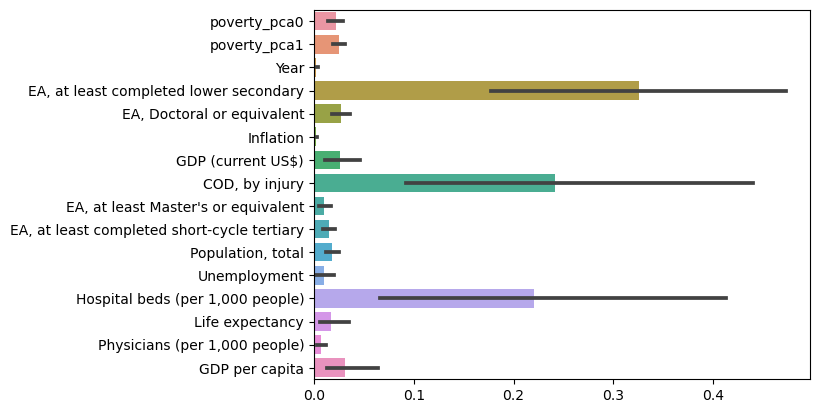

In [33]:
sns.barplot(pd.DataFrame(feature_importances),orient='h')

- Just like the lassolars model, XGBoost also indicates that Hospital beds per 1000 people, Cause of death by injury and lower secondary education as the most important features.

In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'xgb__n_estimators':np.arange(5,150,5),
    'xgb__max_depth':np.arange(2,9),
    'xgb__learning_rate':np.arange(0,1,0.2),
    'xgb__reg_lambda':np.arange(0,2,0.4),
    'xgb__reg_alpha':np.arange(0,1,0.2)
}

random_search = RandomizedSearchCV(xgb,param_distributions=param_grid,cv=gkf,n_iter=450)

random_search.fit(X,y,groups=groups)

RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pca',
                                                                               PCA(n_components=2),
                                                                               [13,
                                                                                14,
                                                                                15,
                                                                                16,
                                                                                17,
                                                                                18])])),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_s...
                                                           random_state=None, ...))]),
                   n_iter=450,
                   param_distributions={'xgb__learning_rate': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'xgb__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                                        'xgb__n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145]),
                                        'xgb__reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'xgb__reg_lambda': array([0. , 0.4, 0.8, 1.2, 1.6])})

In [35]:
random_search.best_score_

0.5737679394343818

In [36]:
random_search.best_params_

{'xgb__reg_lambda': 1.2000000000000002,
 'xgb__reg_alpha': 0.2,
 'xgb__n_estimators': 40,
 'xgb__max_depth': 2,
 'xgb__learning_rate': 0.4}

<h5>K Neighbors vs XG Boost</h5>

- KNN scores a bit better with a score of 0.59 vs 0.57
- xgboost model is more interpretable as we can look at the feature importance.
- While KNN is less computationally expensive with training, it is more expensive for prediction since it requires storing the entire dataset 

Let's see if the residuals between both models can highlight any differences between them.

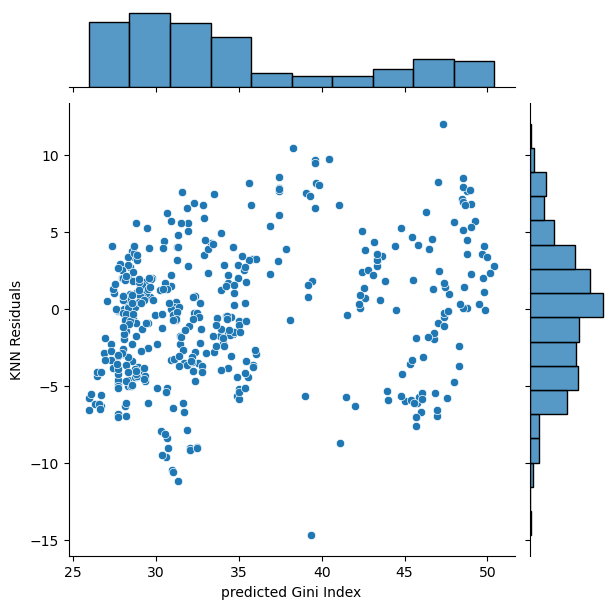

In [37]:
knn_preds = cross_val_predict(grid_search.best_estimator_,X,y,groups=groups,cv=gkf)

sns.jointplot(x=knn_preds,y=knn_preds-y)
plt.xlabel('predicted Gini Index')
plt.ylabel('KNN Residuals')
plt.show()

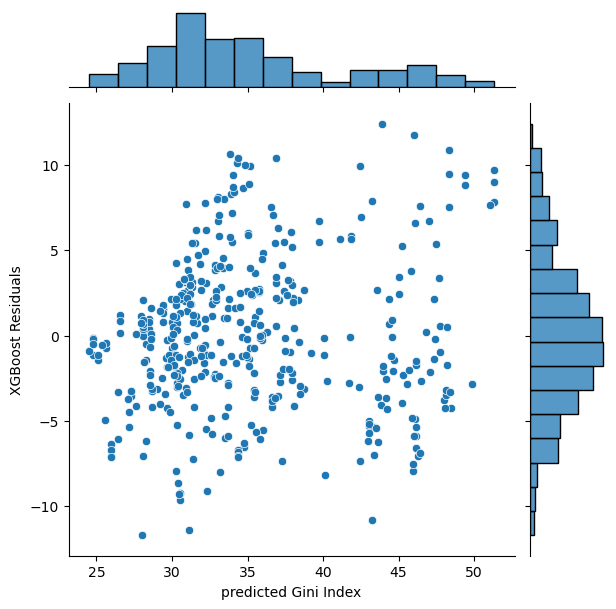

In [38]:
xgb_preds = cross_val_predict(random_search.best_estimator_,X,y,groups=groups,cv=gkf)

sns.jointplot(x=xgb_preds,y=xgb_preds-y)
plt.xlabel('predicted Gini Index')
plt.ylabel('XGBoost Residuals')
plt.show()

Both Models have similar residual graphs but XGBoosts residuals seem to be centered a bit lower than 0

another way to decide is to see which model performs better with less features

In [39]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

xgb_params = random_search.best_params_
xgb_rfe = Pipeline(preprocess_steps + [('rfe',RFE(XGBRegressor())),('xgb',XGBRegressor())])

knn_params = grid_search.best_params_
del knn_params['skb__k']
del knn_params['skb__score_func']
best_knn = KNeighborsRegressor(n_neighbors=12,p=1,weights='uniform')
knn_sfs = Pipeline(preprocess_steps + [('sfs',SequentialFeatureSelector(best_knn)),('knn',KNeighborsRegressor())])

xgb_test_scores = []
knn_test_scores = []

for i in range(1,len(feature_names)):
    knn_model = knn_sfs.set_params(sfs__n_features_to_select=i,**knn_params)
    xgb_model = xgb_rfe.set_params(rfe__n_features_to_select=i,**xgb_params)

    xgb_test_scores.append(np.average(cross_val_score(xgb_model,X,y,groups=groups,cv=gkf)))
    knn_test_scores.append(np.average(cross_val_score(knn_model,X,y,groups=groups,cv=gkf)))


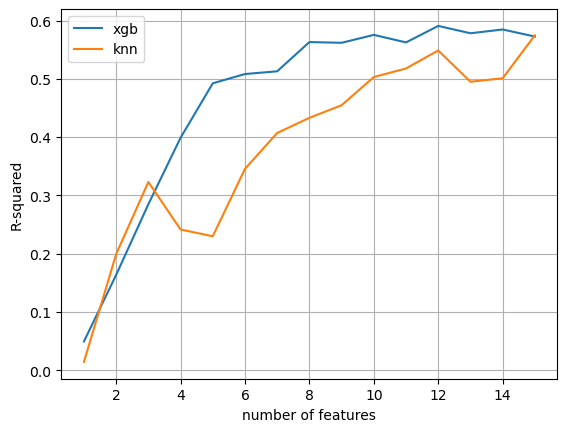

In [40]:
plt.plot(range(1,len(feature_names)),xgb_test_scores) #type: ignore
plt.plot(range(1,len(feature_names)),knn_test_scores) #type: ignore
plt.xlabel('number of features')
plt.ylabel('R-squared')
plt.grid(True)
plt.legend({'xgb':'blue','knn':'orange'})
plt.show()

It looks like xgb is better with less features so that's the model I'll go with

Let's see which features we can drop

In [41]:
from sklearn.feature_selection import RFE

rfe_params = {'reg_lambda': 1.2000000000000002,
 'reg_alpha': 0.2,
 'n_estimators': 115,
 'max_depth': 2,
 'learning_rate': 0.4}

folds = gkf.split(X,y,groups=groups)
scores = []
chosen_features = {}
for f in feature_names:
    chosen_features[f] = 0

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
    preprocessor = Pipeline(steps=preprocess_steps)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    rfe = RFE(XGBRegressor(**rfe_params),n_features_to_select=10)
    rfe.fit(X_train,y_train)
    scores.append(rfe.score(X_test,y_test))
    selected = rfe.get_feature_names_out(feature_names) # type: ignore
    for f in feature_names:
        if f in selected:
            chosen_features[f] += 1

In [42]:
pd.Series(chosen_features) #Number of times features were in the top ten over 5 folds

poverty_pca0                                   5
poverty_pca1                                   4
Year                                           0
EA, at least completed lower secondary         5
EA, Doctoral or equivalent                     3
Inflation                                      0
GDP (current US$)                              4
COD, by injury                                 5
EA, at least Master's or equivalent            3
EA, at least completed short-cycle tertiary    4
Population, total                              4
Unemployment                                   1
Hospital beds (per 1,000 people)               5
Life expectancy                                1
Physicians (per 1,000 people)                  1
GDP per capita                                 5
dtype: int64

Looking above, we can eliminate:
- Year
- Inflation
- Unemployment
- Life expectancy
- Physicians

Through trial, error and looking at permutation importance, I was also able to drop:
- GDP (current US$) 
    - I investigated this as it can be calculated from population and GDP per capita
- Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)
    - showed negative permutation importance
- Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)
    - showed negative permutation importance
- Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)
    - showed low permutation importance

In [46]:
final_features = df.drop(['Inflation',
                          'Unemployment',
                          'Life expectancy',
                          'Physicians (per 1,000 people)','GDP (current US$)',"EA, at least Master's or equivalent",
                          "EA, Doctoral or equivalent",
                          "EA, at least completed short-cycle tertiary"],axis=1)

final_features.to_csv('../data/processed/selected_features.csv')